In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)


In [3]:
from initialization import DatasetInitializer, IdentityInitializer
from layers import DiscriminationModule, ClassificationModule
from loading import SequentialLoader
from metrics import Conncetedness, Consistency

metric1 = Conncetedness()
metric2 = Consistency()
loader = SequentialLoader(mnist_data, num_classes=10)


In [34]:
train_size = 30000
precisions = []
recalls = []
consistencies = []

for epoch in range(100, 600, 100):
    metric1.reset()
    metric2.reset()
    
    precision = []
    recall = []
    consistency = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(1000, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(1000, IdentityInitializer())
    module_c.pruning('on')
    
    for _ in tqdm(range(train_size//epoch), desc=str(epoch)):
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        metric1.update(module_c.connections.T, module_d.labels(10))
        metric2.update(module_d.labels(10))
        
        p, r = metric1.compute()
        c = metric2.compute()
        precision.append(p)
        recall.append(r)
        consistency.append(c)
    
    precisions.append(precision)
    recalls.append(recall)
    consistencies.append(consistency)

100:   0%|          | 0/300 [00:00<?, ?it/s]

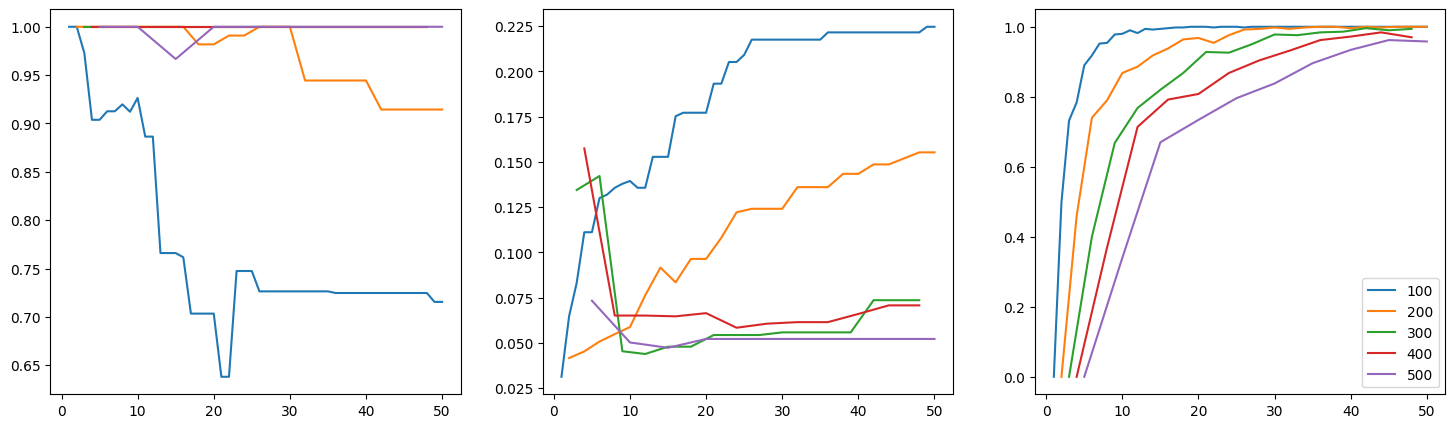

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
for i in range(5):
    x = [*range(i+1, train_size//100+1, i+1)]
    ax[0].plot(x, precisions[i], label=str(100*(i+1)))
    ax[1].plot(x, recalls[i], label=str(100*(i+1)))
    ax[2].plot(x, consistencies[i], label=str(100*(i+1)))
plt.legend()

In [ ]:
train_size = 30000
precisions = []
recalls = []
consistencies = []

for epoch in range(100, 600, 100):
    metric1.reset()
    metric2.reset()
    
    precision = []
    recall = []
    consistency = []
    
    beta = 1 - (1/epoch)
    module_d = DiscriminationModule(1000, DatasetInitializer(dataset=mnist_data, num_classes=10), beta=beta)
    module_c = ClassificationModule(1000, IdentityInitializer())
    #module_c.pruning('on')
    
    for _ in tqdm(range(train_size//epoch), desc=str(epoch)):
        for x in loader(epoch):
            y_ = module_d(x)
            module_c(y_)
        
        module_d.organize()
        module_c.organize()
        metric1.update(module_c.recurrent_weights, module_d.labels(10))
        metric2.update(module_d.labels(10))
        
        p, r = metric1.compute()
        c = metric2.compute()
        precision.append(p)
        recall.append(r)
        consistency.append(c)
    
    precisions.append(precision)
    recalls.append(recall)
    consistencies.append(consistency)

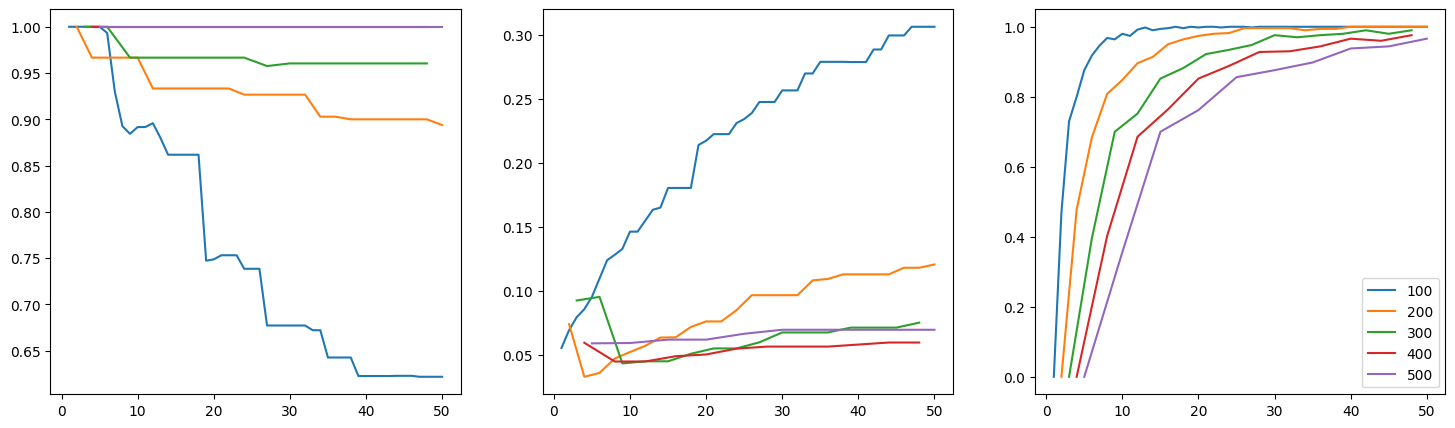

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
for i in range(5):
    x = [*range(i+1, train_size//100+1, i+1)]
    ax[0].plot(x, precisions[i], label=str(100*(i+1)))
    ax[1].plot(x, recalls[i], label=str(100*(i+1)))
    ax[2].plot(x, consistencies[i], label=str(100*(i+1)))
plt.legend()

In [19]:
train_size = 10000
epoch = 200
precisions = []
recalls = []
beta = 1 - 1/epoch

module_d = DiscriminationModule(500, DatasetInitializer(mnist_data, num_classes=10), beta=beta)
module_c = ClassificationModule(500, IdentityInitializer())
#module_c.pruning('on')
metric1.reset()
for eidx in tqdm(range(train_size//epoch)):
    for x in loader(epoch):
        y_ = module_d(x)
        module_c(y_)
    module_c.pruning("on") if eidx > 10 else None
    module_d.organize()
    module_c.organize()
    metric1.update(module_c.connections.T, module_d.labels(10))
    p, r = metric1.compute()
    precisions.append(p)
    recalls.append(r)

100%|██████████| 50/50 [24:20<00:00, 29.22s/it]


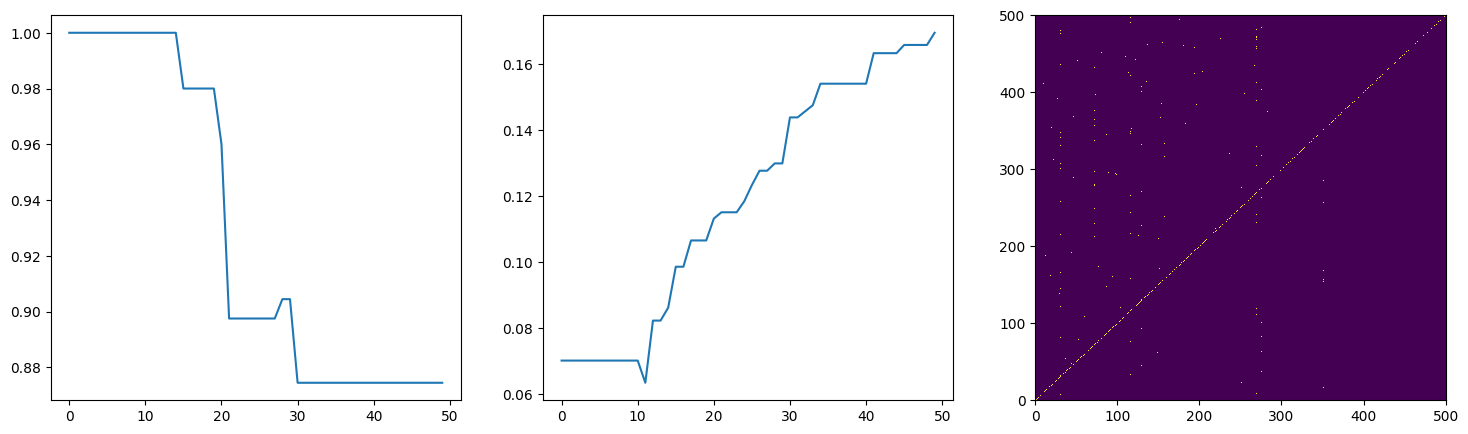

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(precisions)
#ax[0].set_ylim(0.7, 1.01)
#ax[0].axvline(25)
ax[1].plot(recalls)
#ax[1].set_ylim(0.01, 0.06)
#ax[1].axvline(25)
ax[2].pcolormesh(module_c.connections)

/var/folders/b9/8km7dn7s35bfc4y81hgxnfj9d52_hx/T/ipykernel_38299/952859192.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  label_assignments = torch.tensor(label_counts).T[l]


IndexError: index 0 is out of bounds for dimension 0 with size 0

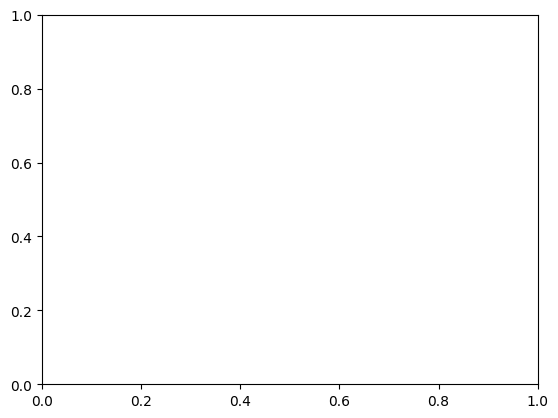

In [18]:
all_labels = module_d.labels(10)
label_counts = []
for row in module_c.connections.T:
    idxs = row.nonzero().flatten()
    if len(idxs) > 2:
        row_label_count = torch.empty(10, dtype=int)
        row_labels = all_labels[idxs]
        labels, counts = torch.unique(row_labels, return_counts=True)
        row_label_count[labels] = counts
        label_counts.append(row_label_count.tolist())
fig, ax = plt.subplots()
bottom = torch.zeros(len(label_counts))
for l in range(10):
    label_assignments = torch.tensor(label_counts).T[l]
    ax.bar(range(len(label_counts)), label_assignments.tolist(), label=str(l), bottom=bottom.tolist())
    bottom += label_assignments
plt.legend()